In [17]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; }
.container {width:95% !important;}
</style>

In [19]:
%matplotlib notebook
import numpy as np
import scipy.fftpack
import matplotlib.pyplot as plt
from matplotlib import animation, patches
from IPython.display import display, Audio, HTML
plt.rcParams['image.cmap'] = 'gray'
from ipywidgets import interact, FloatSlider, IntSlider, SelectionSlider, Layout
from functools import partial
slider_layout = Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
FloatSlider_nice = partial(FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
IntSlider_nice = partial(IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelectionSlider_nice = partial(SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

def color2bw(img):
    return np.dot(img, [0.299, 0.587, 0.114]) 

***
### Universidad Austral de Chile
## Computación de alto rendimiento
# Fast Fourier Transform

### Cristóbal Navarro y Pablo Huijse
 
***

# Serie trigonométrica

Podemos descomponer una señal periódica $P=1/f$ en una suma de sinusoides

$$
\begin{align}
s(t)
&= \sum_{k=0}^\infty A_k \cos(2\pi k f t + \phi_k) \nonumber \\
&= \sum_{k=0}^\infty a_k \cos(2\pi k f t) + b_k \sin(2\pi k f t), \nonumber
\end{align}
$$

donde

$$
a_k =  f \int_{-\frac{1}{2f}}^{\frac{1}{2f}} s(t) \cos(2\pi k f t) \,dt \quad b_k = f \int_{-\frac{1}{2f}}^{\frac{1}{2f}} s(t) \sin(2\pi k f t) \,dt 
$$

<IPython.core.display.Javascript object>


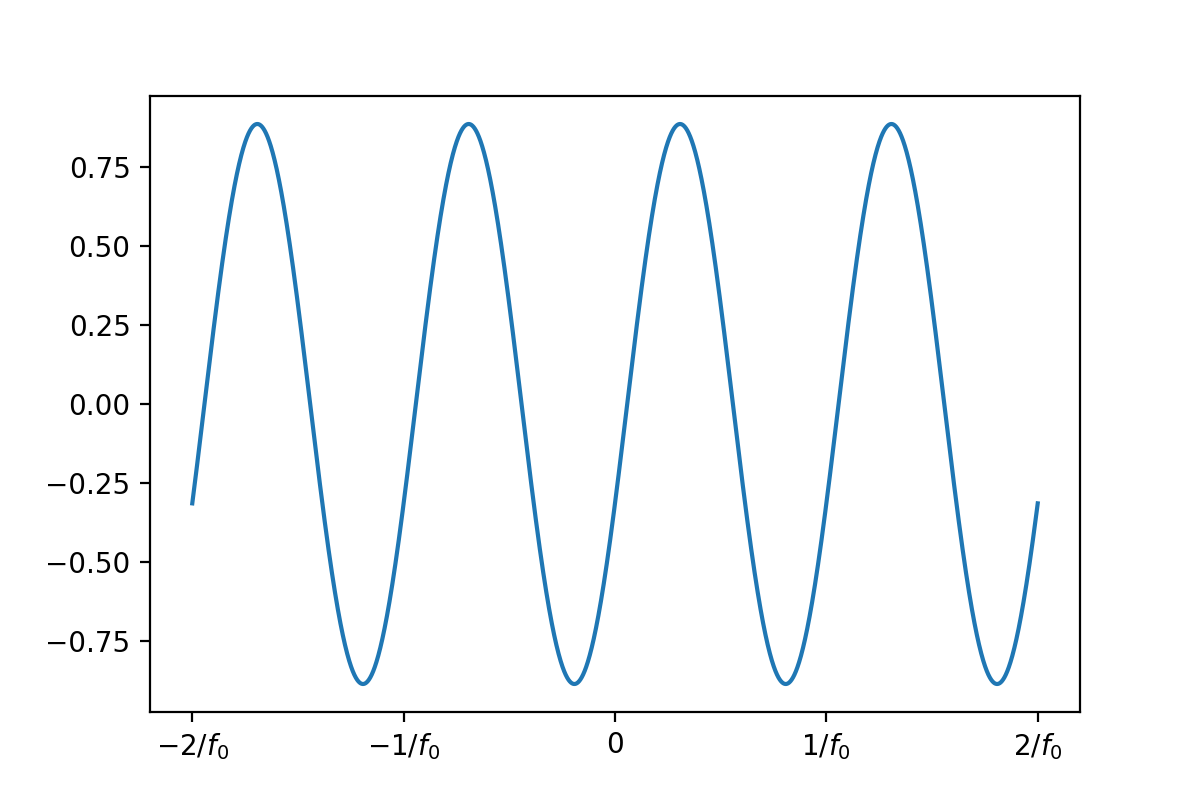

interactive(children=(SelectionSlider(continuous_update=False, description='K', layout=Layout(height='20px', w…

In [21]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(-2/f, 2/f, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f, -1/f, 0, 1/f, 2/f]); 
ax.set_xticklabels([r"$-2/f_0$", r"$-1/f_0$", "0", r"$1/f_0$", r"$2/f_0$"]);
a, b = np.random.randn(101), np.random.randn(101)
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        #y += (1/k)*np.sin(2.0*np.pi*k*f*t)
        #y += (2*np.sin(np.pi*k/2)/(np.pi*k))*np.cos(2.0*np.pi*k*f*t)
        y += a[k]*np.cos(2.0*np.pi*k*f*t)/k**2 + b[k]*np.sin(2.0*np.pi*k*f*t)/k**2
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

Visualización interactiva de la FS: https://bl.ocks.org/jinroh/7524988

Serie de Fourier interesante: https://www.wolframalpha.com/input/?i=longcat+curve

# Transformada de Fourier
***
- El concepto de frecuencia puede aplicarse también a señales no-periódicas
- **Joseph Fourier:** Una señal no-periódica puede ser vista como una señal periódica **con un período infinito**
- El único requisito es que ahora las frecuencias son un continuo, con un espaciado infinitesimal


Directa:
$$
S(\omega) = \mathbb{FT}[s(t)] =  \int_{-\infty}^{\infty} s(t) e^{-j\omega t } dt,
$$

***

Inversa:
$$
s(t) =  \mathbb{FT}^{-1}[S(\omega)] = \frac{1}{2\pi} \int_{-\infty}^{\infty} S(\omega) e^{j \omega t } d\omega,
$$

***

# Discrete Fourier Transform (DFT)

***

- Nos interesa trabajar con señales digitales que están muestreadas en el tiempo
- Asumimos que la señal fue observada en un ventana de tiempo de ancho $T$ [s]
- Sea un sistema muestreador con frecuencia de muestreo $F_s$ [Hz] tal que
$$
s(t) = \sum_{n=0}^{N-1} s[n] \delta(t - n/F_s),
$$
del cual hemos tomado $N = T F_s$ muestras de $s(t)$

<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Sampled.signal.svg" width="600">

- Reemplazando en la transformada de Fourier
$$
\begin{align}
S(\omega) &= \int s(t) e^{-j\omega t} dt \nonumber \\
&= \int \sum_{n=0}^{N-1} s[n] \delta(t - n/F_s) e^{-j\omega t} dt \nonumber \\
&=  \sum_{n=0}^{N-1} s[n] \int \delta(t - n/F_s) e^{-j\omega t} dt \nonumber \\
&=  \sum_{n=0}^{N-1} s[n] e^{-j\omega n/F_s} \nonumber 
\end{align}
$$
- Definiendo entonces $\omega = 2 \pi f = 2 \pi k \Delta f$ donde $\Delta f = \frac{1}{T} = \frac{F_s}{N}$ y reemplazando 
$$
S[k] =  \sum_{n=0}^{N-1} s[n] e^{-j \frac{2 \pi}{N} k n},
$$
donde $k = [0, 1, \ldots N-1]$, ¿A qué frecuencias corresponden estos índices?


***

## DFT como producto matricial

Sea $\{s_n\}_{n=0,\ldots,N-1}$ y definiendo 

$$
W_N = e^{-j \frac{2\pi}{N}} = \cos \left(\frac{2\pi}{N}\right) - j \sin \left(\frac{2\pi}{N}\right)
$$

podemos expresar la transformada de Fourier discreta como

$$
S[k] =  \sum_{n=0}^{N-1} s[n] W_N^{kn}, \quad k = [0, 1, \ldots N-1],
$$

que también puede ser expresado matricialmente como

$$
\begin{align}
\begin{pmatrix} 
S[0] \\
S[1] \\
S[2] \\
\vdots \\
S[N-1] \\
\end{pmatrix} &=
\begin{pmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & W_N^1 & W_N^2 & \cdots & W_N^{N-1} \\
1 & W_N^2 & W_N^4 & \cdots & W_N^{N-2} \\
\vdots & \dots & \dots & \ddots &  \vdots \\
1 & W_N^{N-1} & W_N^{N-2} & \cdots & W_N^1\\
\end{pmatrix} 
\begin{pmatrix} 
s[0] \\
s[1] \\
s[2] \\
\vdots \\
s[N-1] \\
\end{pmatrix} \nonumber  \\
S &= \Omega s,
\end{align}
$$


Notemos que:
- Por definición $W_N^{kn} = \left(e^{-j \frac{2\pi}{N}}\right)^{kn} = e^{-j \frac{2\pi}{N}kn}$
- Por periodicidad $W_N^{2(N-1)} = W_N^{2(N-1) - N}  = W_N^{N-2}$
- También se tiene simetría hermítica: $W_N^{k(-n)} = W_N^{-kn} = (W_N^{kn})^*$
- $\Omega$ es una matriz cuadrada y simétrica 

***
La DFT tiene complejidad cuadrática: $N^2$ multiplicaciones y $N$ sumas
***

In [ ]:
F_s = 100
t = np.linspace(0, 2, 2*F_s, endpoint=False)
x = np.sin(2*np.pi*t*5) + 0.5*np.cos(2*np.pi*t*12 + np.pi/4)

fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(t, x)
ax.set_xlabel('Tiempo [s]'); ax.set_ylabel('Amplitud');


def DFT(x):
    N = len(x)
    W_N = np.exp(-1j*2*np.pi/N)
    n = np.arange(N)
    Omega = W_N**(n*n.reshape(1,-1).T)
    return np.dot(Omega, x)

fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(np.linspace(0, F_s, num=len(t)), np.abs(DFT(x)))
ax.set_xlabel('Frecuencia [Hz]'); 
display(np.angle(DFT(x))[np.abs(DFT(x)) > 10]*180/np.pi);

***

# Transformada Rápida de Fourier (FFT)

***

- La computación de la DFT tiene complejidad $\mathcal{O}(N^2)$
- Existe una aproximación numérica con complejidad $\mathcal{O}(N\log N)$: la Fast Fourier Transform (FFT). 

El algoritmo *radix-2* obtiene una FFT recursiva que explota las simetrías en la DFT

$$
\begin{align}
S[k] &=  \sum_{n=0}^{N-1} s[n] W_N^{kn} \nonumber \\
&= \sum_{n=0}^{N/2-1} s[2n] W_N^{k 2n} + \sum_{n=0}^{N/2-1} s[2n+1] W_N^{k(2n+1)} \nonumber \\
&= \sum_{n=0}^{N/2-1} s[2n] W_{N/2}^{kn} + W_N^{k} \sum_{n=0}^{N/2-1} s[2n+1] W_{N/2}^{kn} \nonumber \\
&= S_E[k] + W_N^{k} S_O[k] ~~ \forall k \in [0,N/2]  \nonumber 
\end{align} 
$$

Notar que se calculan dos "medias" DFT

Por periodicidad de la DFT tenemos que
$$
\begin{align}
S_E[k + N/2] &=  \sum_{n=0}^{N/2-1} s[2n] W_{N/2}^{(k+N/2)n} \nonumber \\
&=  \sum_{n=0}^{N/2-1} s[2n] W_{N/2}^{kn} \exp \left(-j2\pi n \right) = S_E[k], \nonumber
\end{align}
$$

e igualmente

$$
S_O[k + N/2] = S_O[k],
$$

juntando ambos tenemos que
$$
\begin{align}
S[k + N/2] &=  S_E[k + N/2] + W_{N}^{(k+N/2)} S_O[k + N/2] \nonumber  \\
&=  S_E[k] + W_{N}^{k} \exp \left(-j\pi\right) S_O[k] \nonumber \\
&=  S_E[k] - W_{N}^{k} S_O[k] \nonumber 
\end{align}
$$

es decir

$$
\begin{align}
S[k] &=  S_E[k] + W_{N}^{k} S_O[k] \nonumber \\
S[k + N/2] &=  S_E[k] - W_{N}^{k} S_O[k] \quad \forall k \in [0,N/2]  \nonumber 
\end{align}
$$

- La DFT de $k$ y $k+N/2$ difieren en un signo
- Se han explotado las simetrías de la DFT para reducir el costo computacional

Diagramas de mariposa: http://www.themobilestudio.net/the-fourier-transform-part-14

In [ ]:
t = np.linspace(0, 10, num=20)
x = np.random.randn(20)
plt.figure(figsize=(7, 4))
plt.plot(t, x, c='k', alpha=0.5)
plt.scatter(t[::2], x[::2], marker='x', zorder=100)
plt.scatter(t[1::2], x[1::2], marker='o', zorder=100);

In [ ]:
np.set_printoptions(precision=3)
display(scipy.fftpack.fft(x),
        DFT(x))

In [ ]:
S = DFT(x) # N*N multiplicaciones
Se = DFT(x[0::2]) # N/2*N/2 
So = DFT(x[1::2]) # N/2*N/2 
# Se y So = N*N/2 multiplicaciones
display(S[:10],
        Se + np.exp(-1j*2*np.pi*np.arange(10)/len(x))*So,
        S[10:],
        Se - np.exp(-1j*2*np.pi*np.arange(10)/len(x))*So)

# Trabajo práctico

Genere una señal y calcule su transformada de Fourier escribiendo una rutina en C++

Optimize su rutina usando el algoritmo FFT

Paralelice el algoritmo FFT usando OpenMP y CUDA

<IPython.core.display.Javascript object>


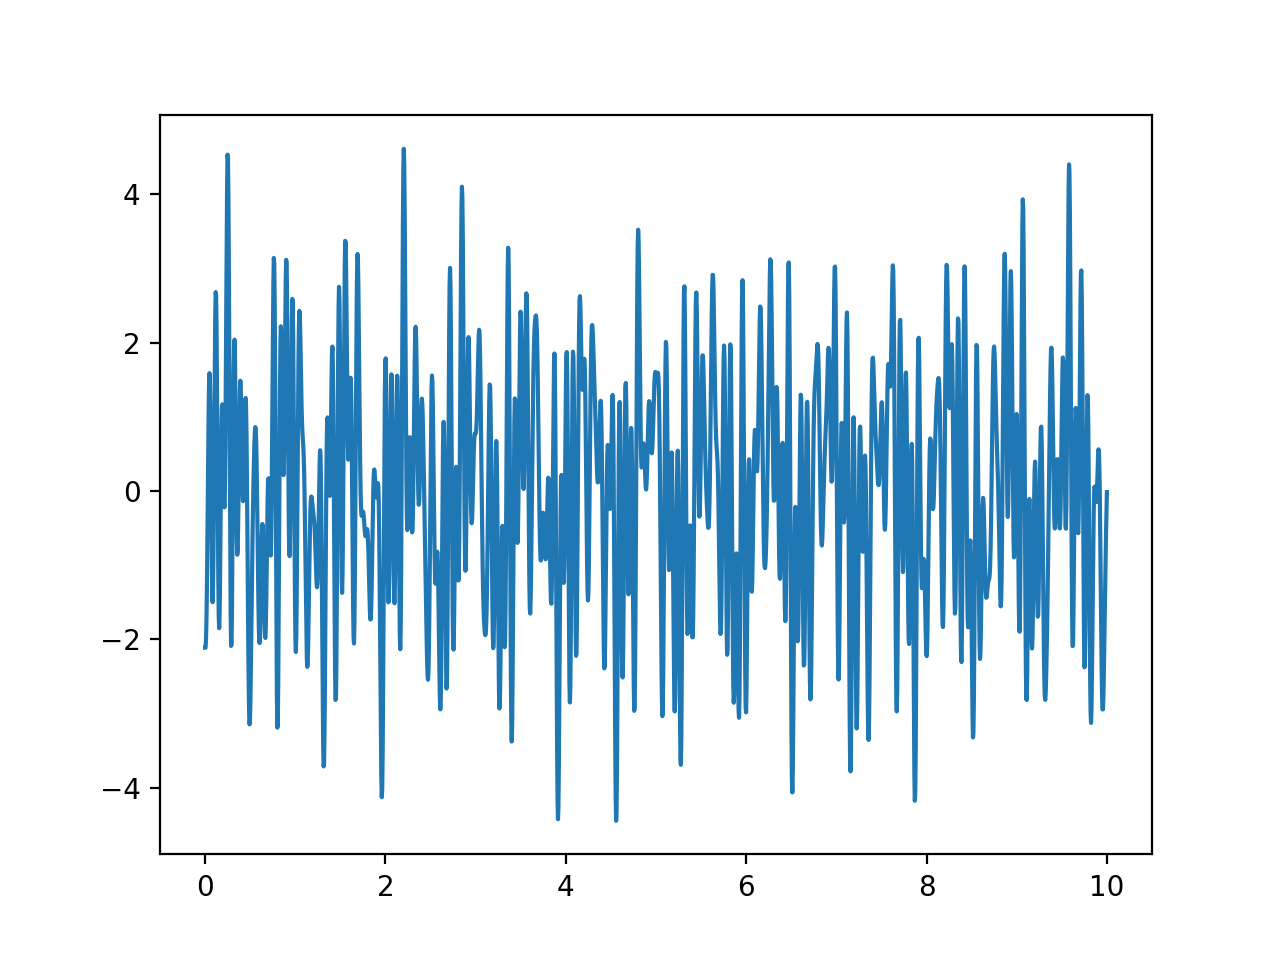

In [23]:
times, dt = np.linspace(0, 10, num=2048, retstep=True)
freqs = 0.01 + 20*np.random.rand(5)
phases = np.pi*np.random.randn(5)
signal = np.zeros(shape=(len(times),))
for freq, phase in zip(freqs, phases):
    signal += np.cos(2.0*np.pi*times*freq + phase)
    
fig, ax = plt.subplots()
ax.plot(times, signal)
np.savetxt('signal.dat', signal)

<IPython.core.display.Javascript object>


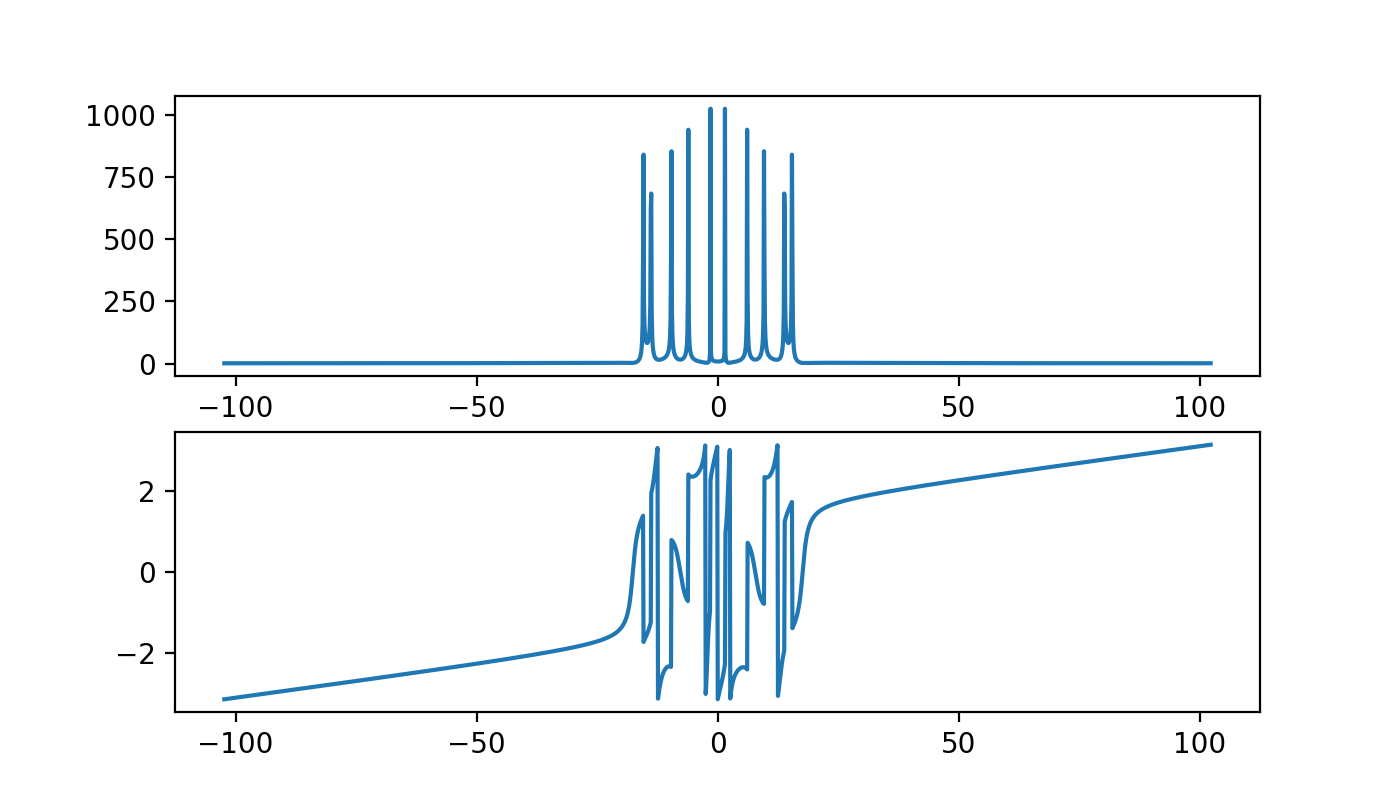

In [24]:
fig, ax = plt.subplots(2, figsize=(7, 4))
SIGNAL = scipy.fftpack.fft(signal, n=len(times))
SIGNAL_plot = scipy.fftpack.fftshift(SIGNAL)
freqs_plot = scipy.fftpack.fftshift(scipy.fftpack.fftfreq(n=len(times), d=dt))
ax[0].plot(freqs_plot, np.abs(SIGNAL_plot))
ax[1].plot(freqs_plot, np.angle(SIGNAL_plot));

In [ ]:
#%%bash
!make
%timeit -n1 !./prog 0
%timeit -n1 !./prog 1
#!./prog 1
!head spectrum.dat
!make clean

In [ ]:
SIGNAL_c = np.loadtxt("spectrum.dat")
SIGNAL_c_complex = SIGNAL_c[:, 0] + 1j*SIGNAL_c[:, 1]
np.allclose(SIGNAL, SIGNAL_c_complex, rtol=1e-9)

In [ ]:
fig, ax = plt.subplots(2, figsize=(7, 4), tight_layout=True)
ax[0].plot(freqs_plot, np.abs(SIGNAL_plot), alpha=0.5)
SIGNAL_c_plot = scipy.fftpack.fftshift(SIGNAL_c_complex)
ax[0].plot(freqs_plot, np.abs(SIGNAL_c_plot), alpha=0.5)
ax[1].plot(freqs_plot, np.abs(SIGNAL_plot) - np.abs(SIGNAL_c_plot));

# Apéndices

## Transformada de Fourier bidimensional

La DFT se puede aplicar a funciones multi-dimensionales. En el caso discreto de una señal bidimensional $g[n_1, n_2]$ con índices $n_1 \in [0, N_1-1]$ y $n_2 \in [0, N_2-1]$ tenemos

$$
G[k_1, k_2] = \sum_{n_1=0}^{N_1-1} \sum_{n_2=0}^{N_2-1} g[n_1, n_2] \exp \left ( -j2\pi  \left[\frac{n_1 k_1}{N_1} + \frac{n_2 k_2}{N_2} \right] \right)
$$
y su inversa

$$
g[n_1, n_2] = \frac{1}{N_1 N_2}\sum_{k_1=0}^{N_1-1} \sum_{k_2=0}^{N_2-1} G[k_1, k_2] \exp \left ( j2\pi  \left[\frac{n_1 k_1}{N_1} + \frac{n_2 k_2}{N_2} \right] \right)
$$

Notemos que

\begin{align}
G[k_1, k_2] &= \sum_{n_1=0}^{N_1-1} \left(\sum_{n_2=0}^{N_2-1} g[n_1, n_2] \exp \left (-j2\pi \frac{n_2 k_2}{N_2}\right) \right) \exp \left (-j2\pi \frac{n_1 k_1}{N_1}\right) \\
&= \sum_{n_1=0}^{N_1-1} \gamma_{n_1}[n_2] \exp \left (-j2\pi \frac{n_1 k_1}{N_1}\right),
\end{align}

*i.e.* se descompone como dos DFT de una dimensión. En cada paso podemos usar la FFT

<IPython.core.display.Javascript object>


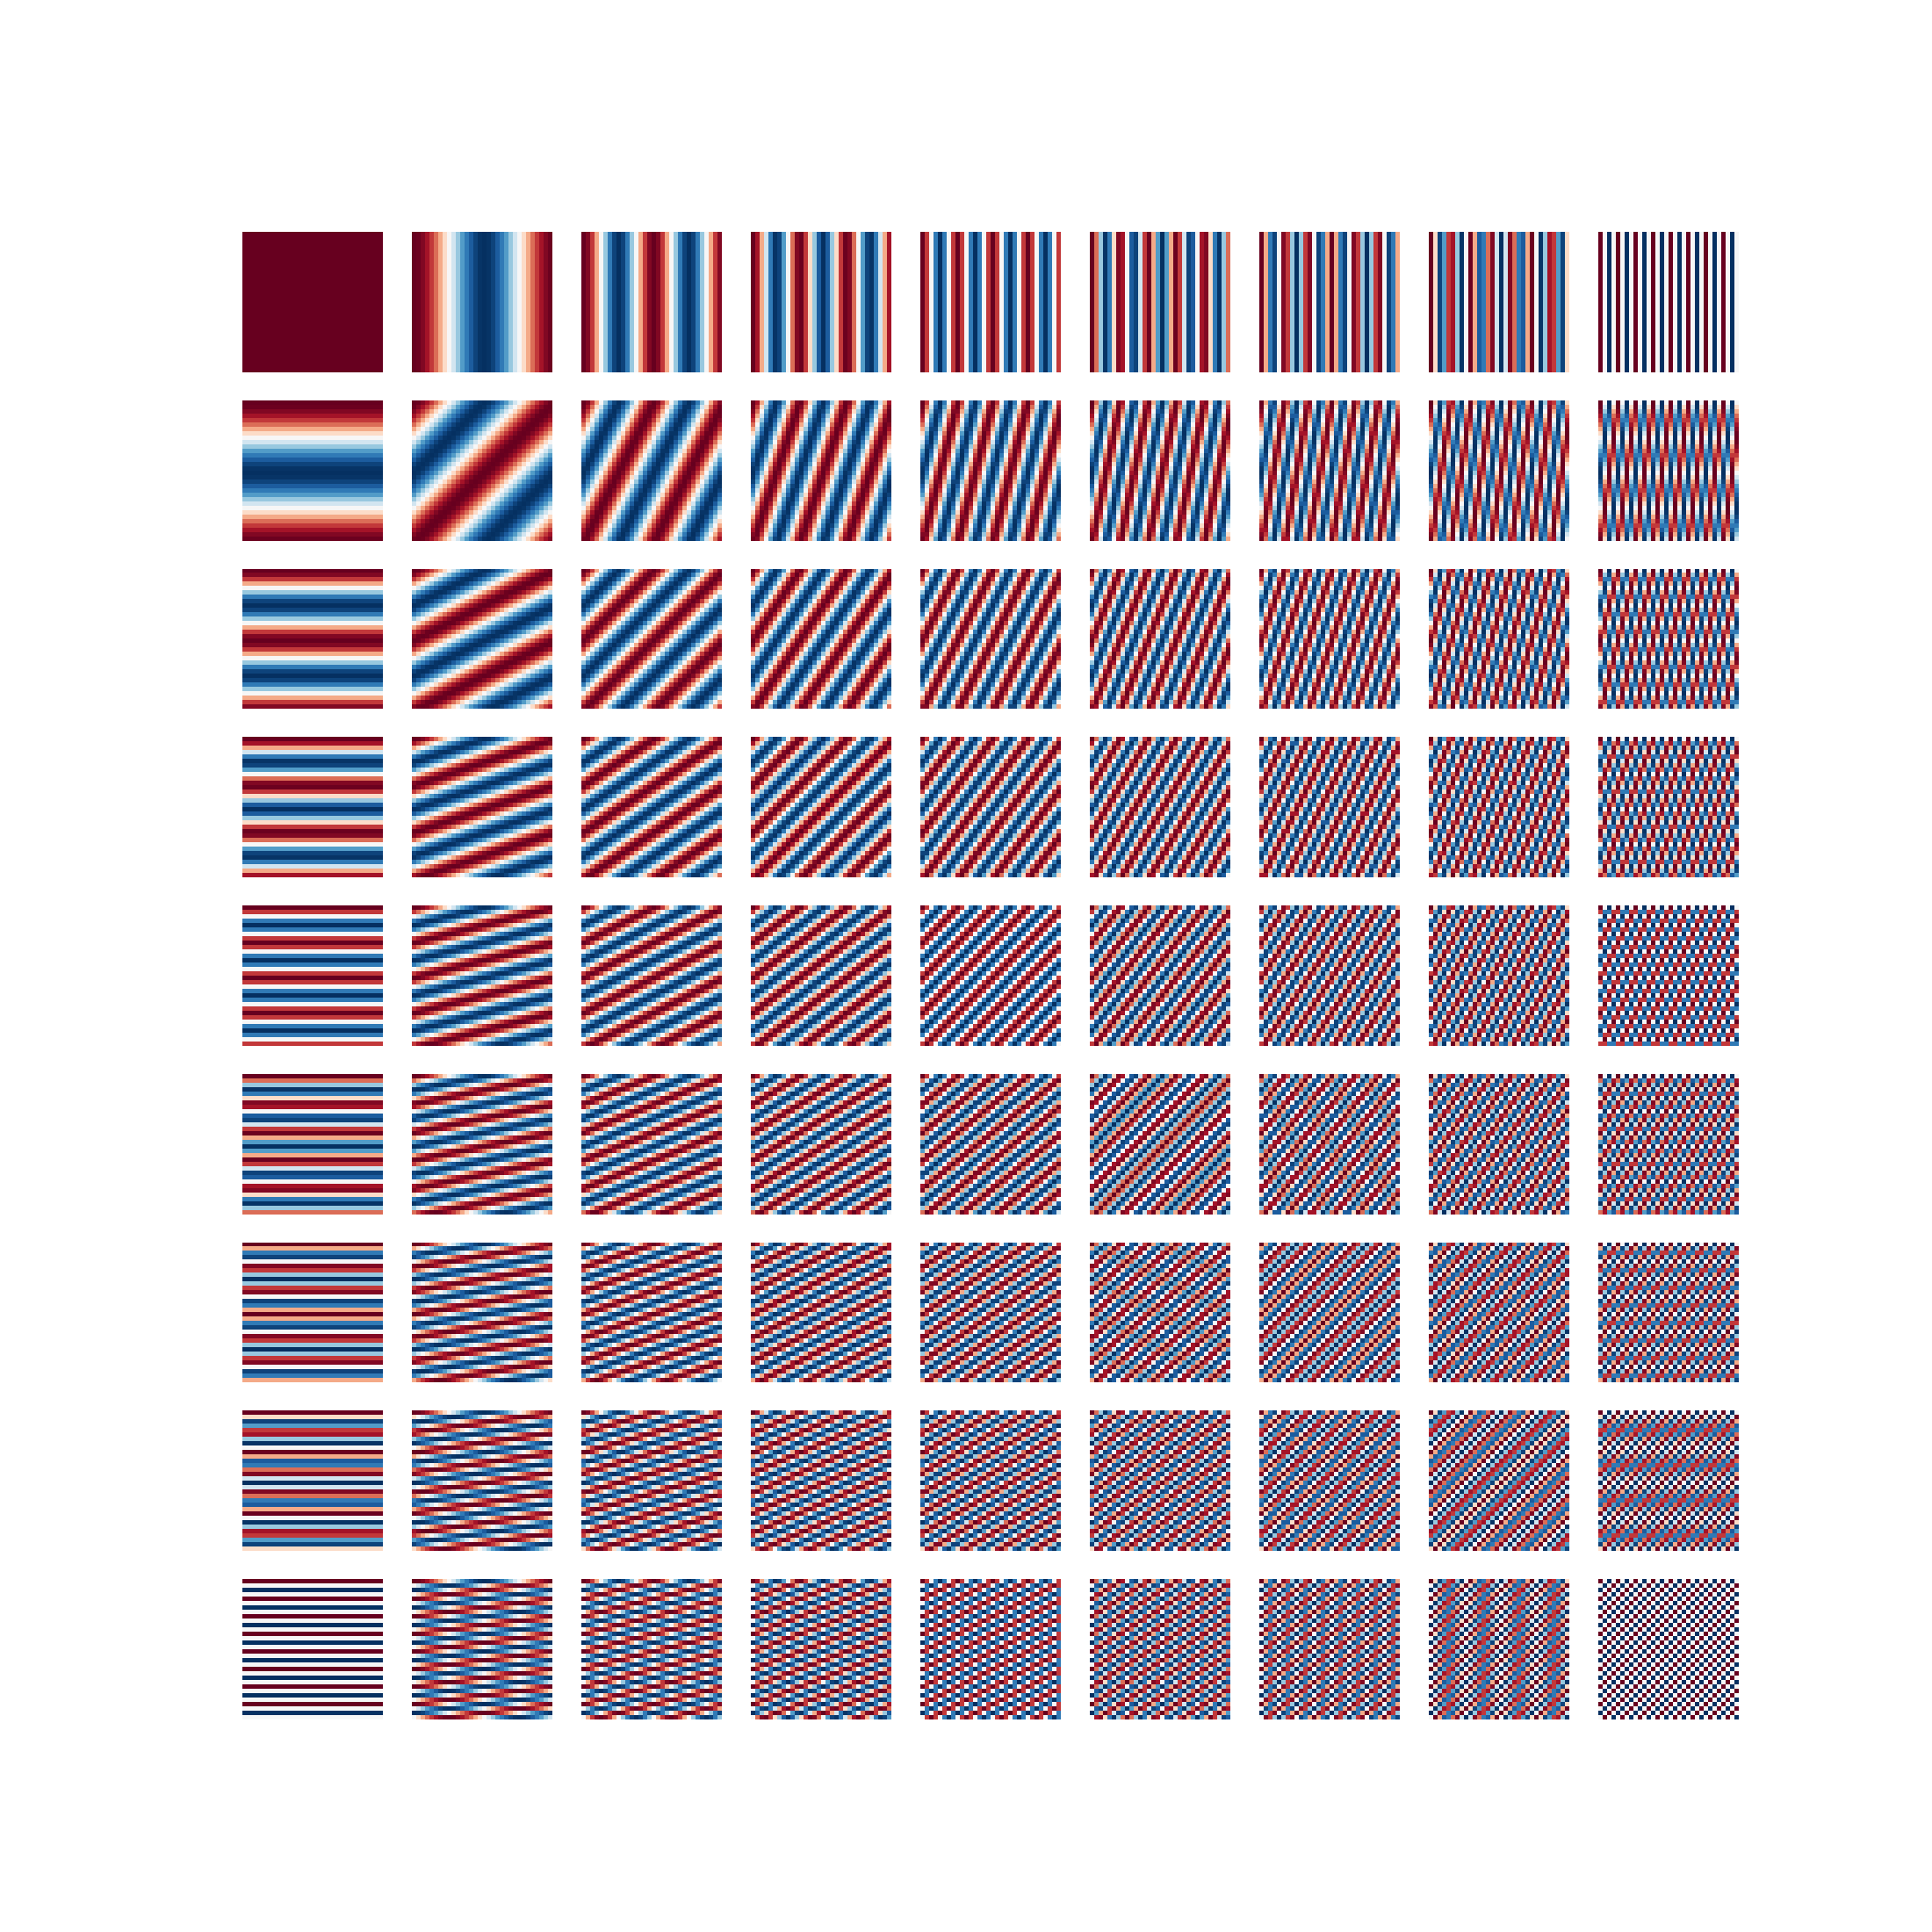

In [22]:
x = np.arange(0, 32, step=1)
X, Y = np.meshgrid(x, x)
fig, ax = plt.subplots(9, 9, figsize=(11, 11), tight_layout=False)
for n in range(9):
    for m in range(9):
        ax[n, m].matshow(np.cos(2.0*np.pi*X*m/len(x) + 2.0*np.pi*Y*n/len(x)), 
                         cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
        ax[n, m].axis('off')

In [ ]:
img_doge = color2bw(plt.imread('doge.jpg')) 

plt.figure(figsize=(8, 5))
plt.imshow(img_doge)
plt.colorbar(orientation='horizontal');

In [ ]:
from scipy import fftpack
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
S_img = fftpack.fft2(img_doge)
im = ax[0].imshow(fftpack.fftshift(np.log(1.+np.abs(S_img))))
fig.colorbar(im, ax=ax[0], orientation='horizontal')
im = ax[1].imshow(fftpack.fftshift(np.angle(S_img)))  # arctan(imag/real)
fig.colorbar(im, ax=ax[1], orientation='horizontal');

In [ ]:
plt.close('all'); fig, ax = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True);
cy, cx = img_doge.shape[0]/2, img_doge.shape[1]/2
x = np.arange(0, img_doge.shape[1]); y = np.arange(0, img_doge.shape[0]);
X, Y = np.meshgrid(x, y)

def update(sigma1=1, sigma2=1):
    for ax_ in ax:
        ax_.cla()
        ax_.axis('off')
    mask1 = np.exp(-(((X-cx)/sigma1)**2 + ((Y-cy)/sigma1)**2)) 
    mask2 = np.exp(-(((X-cx)/sigma2)**2 + ((Y-cy)/sigma2)**2)) 
    im = ax[0].imshow(fftpack.fftshift(np.log(1.0+np.abs(S_img)))*(mask1-mask2))
    im = ax[1].imshow(np.real(fftpack.ifft2(fftpack.ifftshift(fftpack.fftshift(S_img)*(mask1-mask2)))))
interact(update, sigma1=FloatSlider_nice(min=1, max=200.0, value=200, description="$\sigma_1$"),
        sigma2=FloatSlider_nice(min=1, max=200.0, value=1, description="$\sigma_2$"));